In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [ ]:
brain_df = pd.read_csv('/content/drive/MyDrive/new kaggle data/kaggle_3m/data.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/new kaggle data/kaggle_3m//"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/drive/MyDrive/new kaggle data/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/new kaggle data/kaggle_3m/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id" : [i[:] for i in data_map[::2]],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_CS_4941_19960909  /content/drive/MyDrive/new kaggle data/kaggle_...
1  TCGA_CS_4941_19960909  /content/drive/MyDrive/new kaggle data/kaggle_...
2  TCGA_CS_4941_19960909  /content/drive/MyDrive/new kaggle data/kaggle_...
3  TCGA_CS_4941_19960909  /content/drive/MyDrive/new kaggle data/kaggle_...
4  TCGA_CS_4941_19960909  /content/drive/MyDrive/new kaggle data/kaggle_...

In [ ]:
len("/content/drive/MyDrive/new kaggle data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_")

84

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 84 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))



In [ ]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_CS_4941_19960909   
1     TCGA_CS_4941_19960909   
2     TCGA_CS_4941_19960909   
3     TCGA_CS_4941_19960909   
4     TCGA_CS_4941_19960909   
...                     ...   
3924  TCGA_HT_A61B_19991127   
3925  TCGA_HT_A61B_19991127   
3926  TCGA_HT_A61B_19991127   
3927  TCGA_HT_A61B_19991127   
3928  TCGA_HT_A61B_19991127   

                                             image_path  \
0     /content/drive/MyDrive/new kaggle data/kaggle_...   
1     /content/drive/MyDrive/new kaggle data/kaggle_...   
2     /content/drive/MyDrive/new kaggle data/kaggle_...   
3     /content/drive/MyDrive/new kaggle data/kaggle_...   
4     /content/drive/MyDrive/new kaggle data/kaggle_...   
...                                                 ...   
3924  /content/drive/MyDrive/new kaggle data/kaggle_...   
3925  /content/drive/MyDrive/new kaggle data/kaggle_...   
3926  /content/drive/MyDrive/new kaggle data/kaggle_...   
3927  /content/drive/MyDrive/new kaggle data/kaggle_...   
3928  /content/drive/MyDrive/new kaggle data/kaggle_...   

                                              mask_path  mask  
0     /content/drive/MyDrive/new kaggle data/kaggle_...     0  
1     /content/drive/MyDrive/new kaggle data/kaggle_...     0  
2     /content/drive/MyDrive/new kaggle data/kaggle_...     0  
3     /content/drive/MyDrive/new kaggle data/kaggle_...     0  
4     /content/drive/MyDrive/new kaggle data/kaggle_...     0  
...                                                 ...   ...  
3924  /content/drive/MyDrive/new kaggle data/kaggle_...     0  
3925  /content/drive/MyDrive/new kaggle data/kaggle_...     0  
3926  /content/drive/MyDrive/new kaggle data/kaggle_...     0  
3927  /content/drive/MyDrive/new kaggle data/kaggle_...     0  
3928  /content/drive/MyDrive/new kaggle data/kaggle_...     0  

[3929 rows x 4 columns]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.show()

In [ ]:
brain_df.mask_path

0       /content/drive/MyDrive/new kaggle data/kaggle_...
1       /content/drive/MyDrive/new kaggle data/kaggle_...
2       /content/drive/MyDrive/new kaggle data/kaggle_...
3       /content/drive/MyDrive/new kaggle data/kaggle_...
4       /content/drive/MyDrive/new kaggle data/kaggle_...
                              ...                        
3924    /content/drive/MyDrive/new kaggle data/kaggle_...
3925    /content/drive/MyDrive/new kaggle data/kaggle_...
3926    /content/drive/MyDrive/new kaggle data/kaggle_...
3927    /content/drive/MyDrive/new kaggle data/kaggle_...
3928    /content/drive/MyDrive/new kaggle data/kaggle_...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
brain_df.image_path

0       /content/drive/MyDrive/new kaggle data/kaggle_...
1       /content/drive/MyDrive/new kaggle data/kaggle_...
2       /content/drive/MyDrive/new kaggle data/kaggle_...
3       /content/drive/MyDrive/new kaggle data/kaggle_...
4       /content/drive/MyDrive/new kaggle data/kaggle_...
                              ...                        
3924    /content/drive/MyDrive/new kaggle data/kaggle_...
3925    /content/drive/MyDrive/new kaggle data/kaggle_...
3926    /content/drive/MyDrive/new kaggle data/kaggle_...
3927    /content/drive/MyDrive/new kaggle data/kaggle_...
3928    /content/drive/MyDrive/new kaggle data/kaggle_...
Name: image_path, Length: 3929, dtype: object

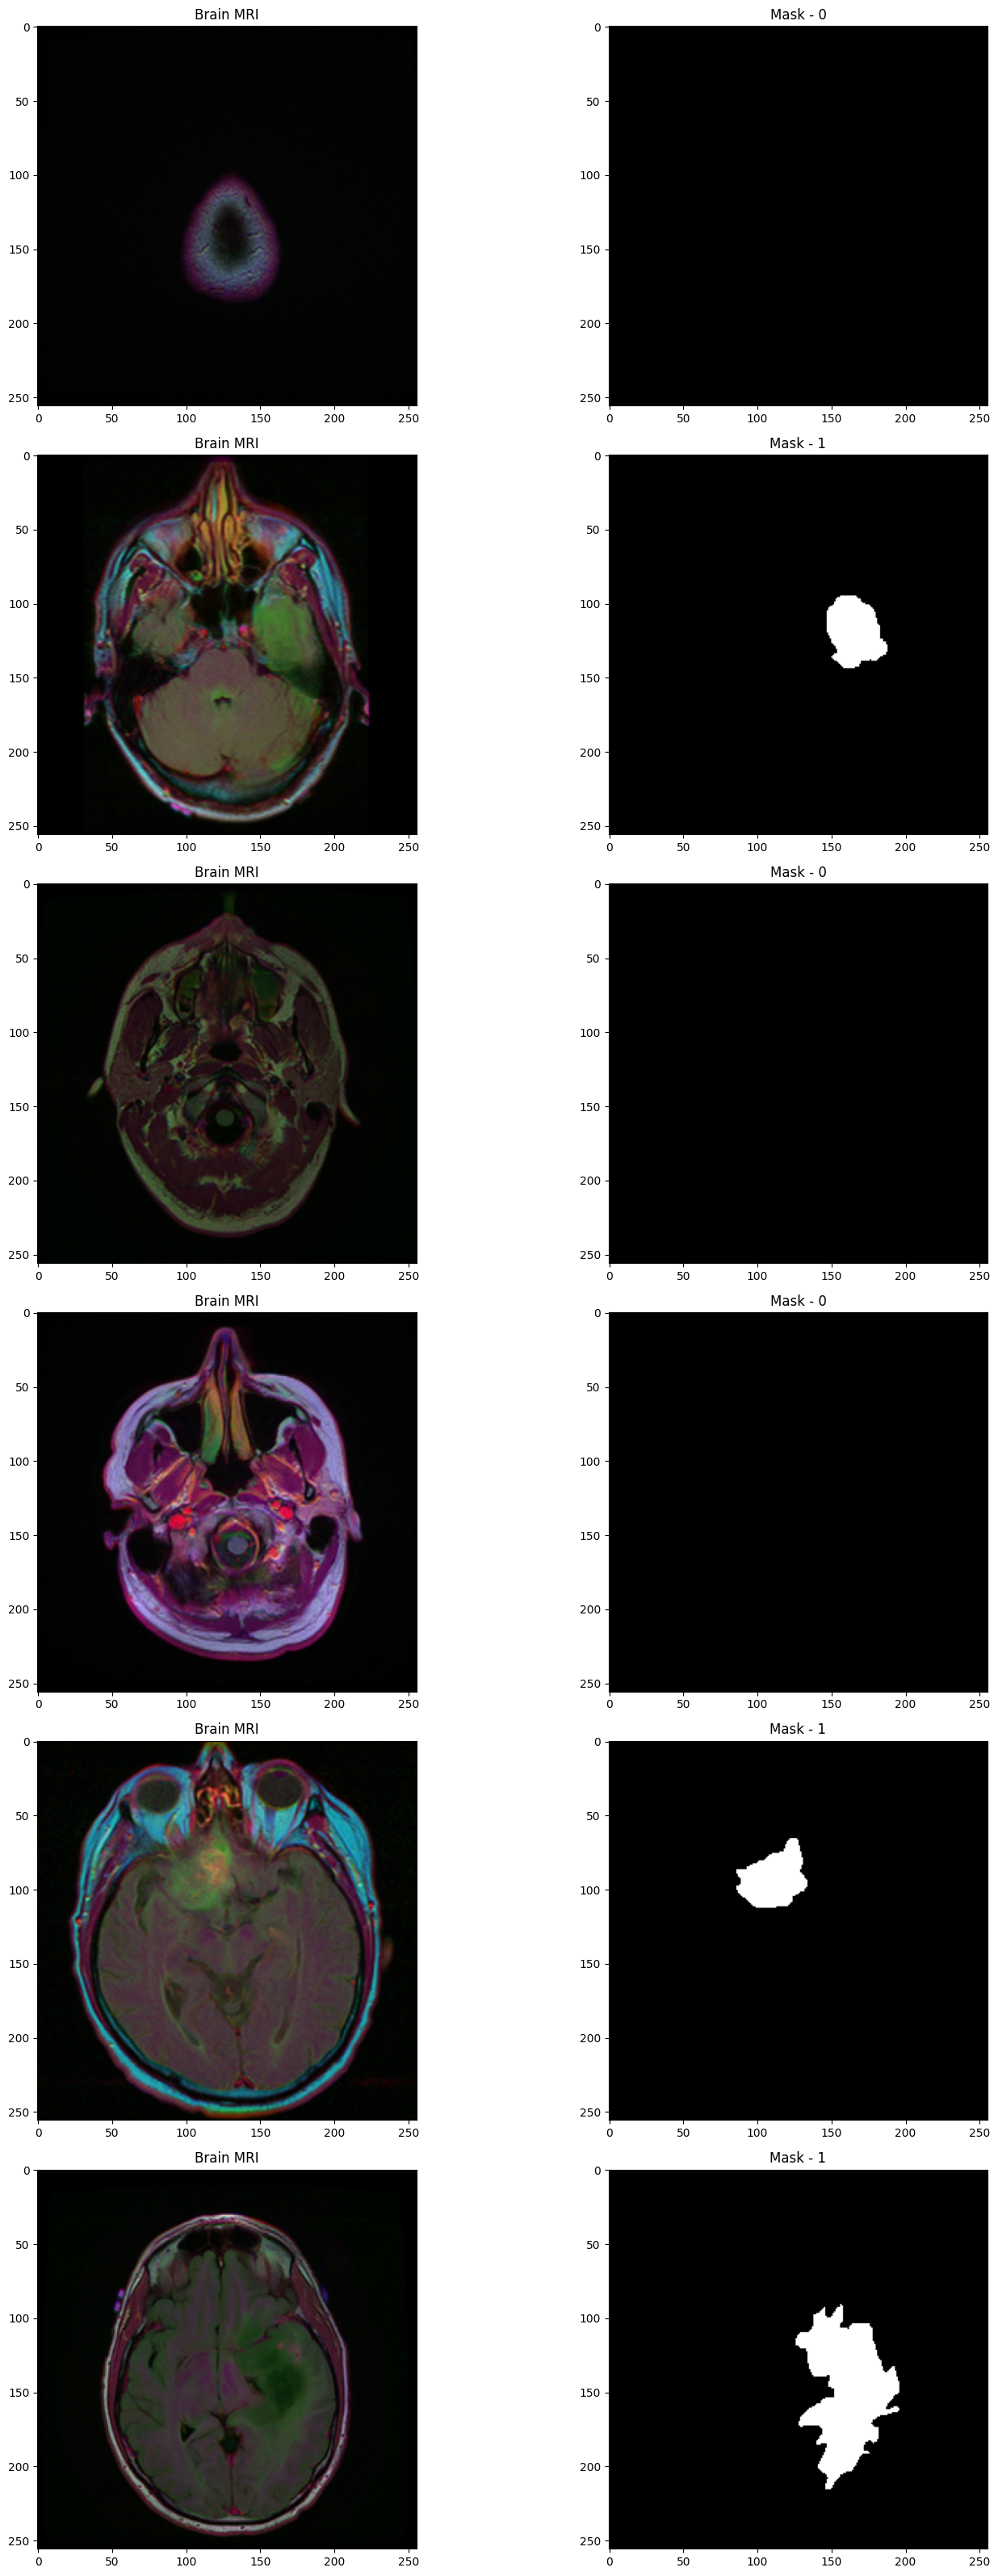

In [ ]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df)) # select a random index
    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
    count += 1

fig.tight_layout()

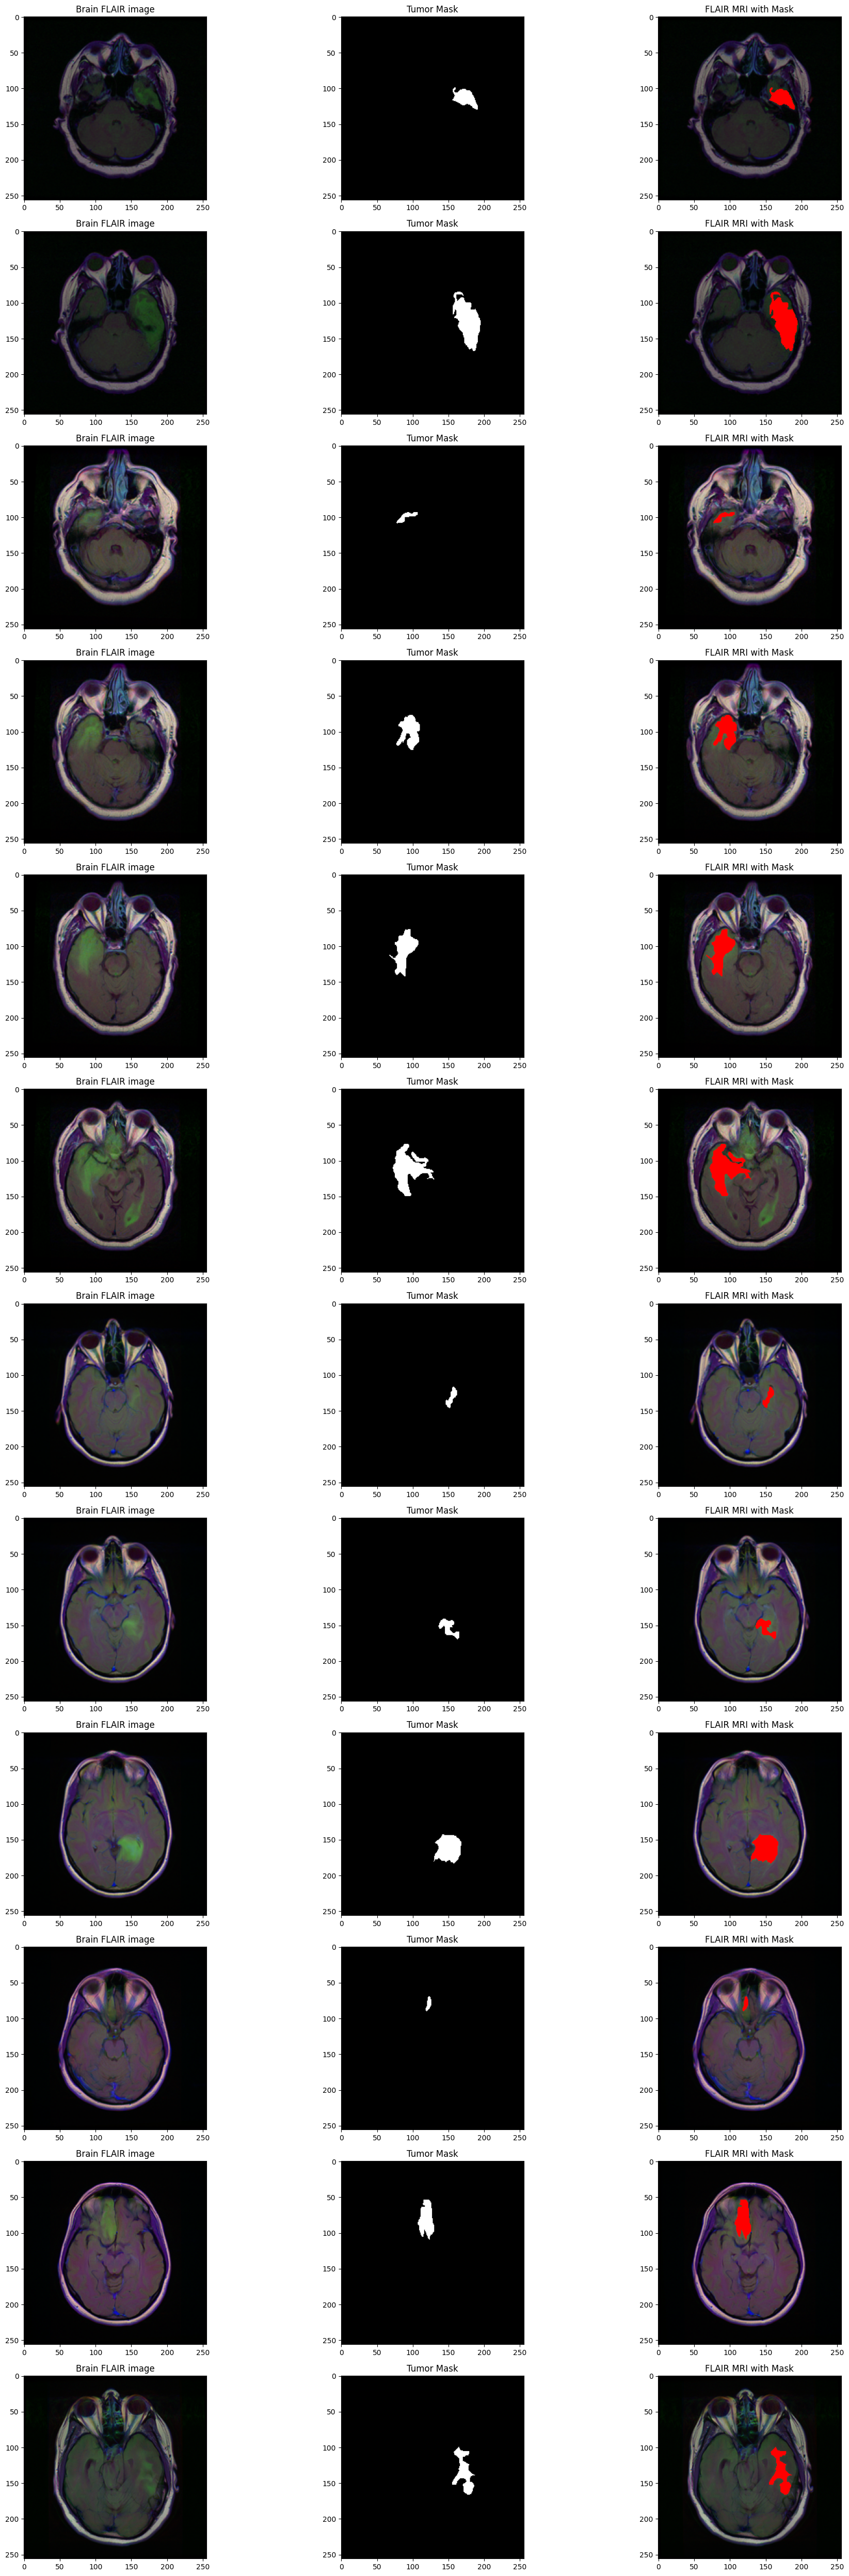

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
    if brain_df['mask'][i] ==1 and count <12:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text('Brain FLAIR image')
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text('Tumor Mask')
        axs[count][1].imshow(mask, cmap = 'gray')

        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text('FLAIR MRI with Mask')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()

In [ ]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 500 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 590 validated image filenames belonging to 2 classes.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/classifier-resnet-weights.hdf5", verbose=1,
                               save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20,
                    validation_data= valid_generator, validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, earlystopping])

In [ ]:
pd.DataFrame(history.history)

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model.load_weights('/content/drive/MyDrive/classifier-resnet-weights.hdf5')

In [ ]:
model.evaluate(test_generator)

In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
y_pred

In [ ]:
y_hat = np.argmax(y_pred, axis = 1)
y_test = np.asarray(test['mask']).astype('int')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
confusion_matrix(y_test, y_hat)

In [ ]:
res_acc = accuracy_score(y_test, y_hat)
res_acc

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_hat), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [ ]:
print(classification_report(y_test, y_hat))

In [ ]:
basemodel1 = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= (256, 256, 3), pooling= None)


In [ ]:
basemodel1.summary()

In [ ]:
for layer in basemodel1.layers:
  layers.trainable = False

In [ ]:
headmodel1 = basemodel1.output
headmodel1 = MaxPooling2D(pool_size = (4,4))(headmodel1)
headmodel1 = Flatten(name= 'flatten')(headmodel1)
headmodel1 = Dense(256, activation = "relu")(headmodel1)
headmodel1 = Dropout(0.3)(headmodel1)#
headmodel1 = Dense(256, activation = "relu")(headmodel1)
headmodel1 = Dropout(0.3)(headmodel1)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel1 = Dense(2, activation = 'softmax')(headmodel1)

model1 = Model(inputs = basemodel1.input, outputs = headmodel1)

In [ ]:
model1.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
#checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/classifier-resnet-weights.hdf5", verbose=1,save_best_only=True)
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/classifier-xception-weights.hdf5", verbose=1,
                               save_best_only=True)

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
history1 = model1.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20,
                    validation_data= valid_generator, validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, earlystopping])

In [ ]:
pd.DataFrame(history1.history)

In [ ]:
pd.DataFrame(history1.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model1.load_weights('/content/drive/MyDrive/classifier-xception-weights.hdf5')

In [ ]:
model1.evaluate(test_generator)

In [ ]:
y_pred_1 = model1.predict(test_generator)

In [ ]:
y_hat_1 = np.argmax(y_pred_1, axis = 1)
y_test_1 = np.asarray(test['mask']).astype('int')

In [ ]:
xce_acc = accuracy_score(y_test_1, y_hat_1)
xce_acc

In [ ]:
confusion_matrix(y_test_1, y_hat_1)

In [ ]:
sns.heatmap(confusion_matrix(y_test_1, y_hat_1), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [ ]:
print(classification_report(y_test_1, y_hat_1))

In [ ]:
model2 = Sequential()
model2.add(Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# prompt: run the model2 for the train_generator and for the test_generatot

history2 = model2.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 10,
                    validation_data= valid_generator, validation_steps= valid_generator.n // 16)
model2.evaluate(test_generator)


In [ ]:
model2.build()
model2.summary()

In [ ]:
pd.DataFrame(history2.history)

In [ ]:
pd.DataFrame(history1.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model2.evaluate(test_generator)

In [ ]:
y_pred_2 = model2.predict(test_generator)

In [ ]:
y_hat_2 = np.argmax(y_pred_2, axis = 1)
y_test_2 = np.asarray(test['mask']).astype('int')

In [ ]:
confusion_matrix(y_test_2, y_hat_2)

In [ ]:
sns.heatmap(confusion_matrix(y_test_2, y_hat_2), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [ ]:
print(classification_report(y_test_2, y_hat_2))

In [ ]:
basemodel3 = tf.keras.applications.InceptionV3(include_top= False,weights= "imagenet",
                                            input_shape= (256, 256, 3), pooling= None)

In [ ]:
basemodel3.summary()

In [ ]:
print(dir(basemodel3))

In [ ]:
headmodel3 = basemodel3.output
headmodel3 = MaxPooling2D(pool_size = (4,4))(headmodel3)
headmodel3 = Flatten(name='flatten')(headmodel3)
headmodel3 = Dense(256, activation = "relu")(headmodel3)
headmodel3 = Dropout(0.3)(headmodel3)
headmodel3 = Dense(256, activation = "relu")(headmodel3)
headmodel3 = Dropout(0.3)(headmodel3)
headmodel3 = Dense(2, activation = 'softmax')(headmodel3)

model3 = Model(inputs = basemodel3.input, outputs = headmodel3)

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/classifier-inceptionv3-weights.hdf5", verbose=1,
                               save_best_only=True)

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
history3 = model3.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20,
                    validation_data= valid_generator, validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, earlystopping])

In [ ]:
pd.DataFrame(history3.history)

In [ ]:
pd.DataFrame(history3.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model3.load_weights('/content/drive/MyDrive/classifier-inceptionv3-weights.hdf5')

In [ ]:
model3.evaluate(test_generator)

In [ ]:
y_pred_3 = model3.predict(test_generator)

In [ ]:
y_hat_3 = np.argmax(y_pred_3, axis = 1)
y_test_3 = np.asarray(test['mask']).astype('int')

In [ ]:
inc_acc = accuracy_score(y_test_3, y_hat_3)
inc_acc

In [ ]:
confusion_matrix(y_test_3, y_hat_3)

In [ ]:
sns.heatmap(confusion_matrix(y_test_3, y_hat_3), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [ ]:
print(classification_report(y_test_3, y_hat_3))

In [ ]:
basemodel4 = tf.keras.applications.VGG19(include_top= False,weights= "imagenet",
                                            input_shape= (256, 256, 3), pooling= None)

In [ ]:
basemodel4.summary()

In [ ]:
headmodel4 = basemodel4.output
headmodel4 = MaxPooling2D(pool_size = (4,4))(headmodel4)
headmodel4 = Flatten(name='flatten')(headmodel4)
headmodel4 = Dense(256, activation = "relu")(headmodel4)
headmodel4 = Dropout(0.3)(headmodel4)
headmodel4 = Dense(256, activation = "relu")(headmodel4)
headmodel4 = Dropout(0.3)(headmodel4)
headmodel4 = Dense(2, activation = 'softmax')(headmodel4)

model4 = Model(inputs = basemodel4.input, outputs = headmodel4)

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/classifier-vgg19-weights.hdf5", verbose=1,
                               save_best_only=True)

In [ ]:
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
history4 = model4.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 10,
                    validation_data= valid_generator, validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, earlystopping])

In [ ]:
pd.DataFrame(history4.history)

In [ ]:
pd.DataFrame(history4.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model4.load_weights('/content/drive/MyDrive/classifier-vgg19-weights.hdf5')

In [ ]:
model4.evaluate(test_generator)

In [ ]:
y_pred_4 = model4.predict(test_generator)

In [ ]:
y_hat_4 = np.argmax(y_pred_4, axis = 1)
y_test_4 = np.asarray(test['mask']).astype('int')

In [ ]:
vgg_acc = accuracy_score(y_test_4, y_hat_4)
vgg_acc

In [ ]:
confusion_matrix(y_test_4, y_hat_4)

In [ ]:
sns.heatmap(confusion_matrix(y_test_4, y_hat_4), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [ ]:
print(classification_report(y_test_4, y_hat_4))

In [ ]:
basemodel5 = tf.keras.applications.MobileNetV2(include_top= False,weights= "imagenet",
                                            input_shape= (256, 256, 3), pooling= None)

In [ ]:
basemodel5.summary()

In [ ]:
headmodel5 = basemodel5.output
headmodel5 = MaxPooling2D(pool_size = (4,4))(headmodel5)
headmodel5 = Flatten(name='flatten')(headmodel5)
headmodel5 = Dense(256, activation = "relu")(headmodel5)
headmodel5 = Dropout(0.3)(headmodel5)
headmodel5 = Dense(256, activation = "relu")(headmodel5)
headmodel5 = Dropout(0.3)(headmodel5)
headmodel5 = Dense(2, activation = 'softmax')(headmodel5)

model5 = Model(inputs = basemodel5.input, outputs = headmodel5)

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/classifier-mobilenetv2-weights.hdf5", verbose=1,
                               save_best_only=True)

In [ ]:
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
history5 = model5.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20,
                    validation_data= valid_generator, validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, earlystopping])

In [ ]:
pd.DataFrame(history5.history)

In [ ]:
pd.DataFrame(history5.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model5.load_weights('/content/drive/MyDrive/classifier-mobilenetv2-weights.hdf5')

In [ ]:
model5.evaluate(test_generator)

In [ ]:
y_pred_5 = model5.predict(test_generator)

In [ ]:
y_hat_5 = np.argmax(y_pred_5, axis = 1)
y_test_5 = np.asarray(test['mask']).astype('int')

In [ ]:
mob_acc = accuracy_score(y_test_5, y_hat_5)
mob_acc

In [ ]:
confusion_matrix(y_test_5, y_hat_5)

In [ ]:
sns.heatmap(confusion_matrix(y_test_5, y_hat_5), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [ ]:
print(classification_report(y_test_5, y_hat_5))

In [ ]:
model_outcome = {"S.no" : [1,2,3,4,5],
    "Models" : ["ResNet50","Xception","InceptionV3","VGG19","MobileNetV2"],
    "Accuracy" : [94.4067,96.9491,94.2372,64.4067,62.0338]}

In [ ]:
import pandas as pd

In [ ]:
out_data = pd.DataFrame(model_outcome)

In [ ]:
out_data.head()